# CS6120 NLP Fall 2023 Assignment 3

## Implementing Skipgram and CBOW Algorithms

### Background: 
Word embeddings are dense vector representations of words in a continuous vector space. Skipgram and CBOW are two primary algorithms introduced by Mikolov et al. in their 2013 papers that form the basis of the popular word2vec model. While both are used for generating word embeddings, they use different architectures and techniques.

- Skipgram: Given a word, this model predicts the surrounding context words.
- CBOW (Continuous Bag-of-Words): Given context words, this model predicts the target word.

### Tasks:
1. Data Collection:
Download the text8 dataset, which is a cleaned version of the first 100MB of the English Wikipedia dump. It is available on several NLP data repositories.



In [2]:
import requests

# Download the dataset
url = "http://mattmahoney.net/dc/text8.zip"
response = requests.get(url, allow_redirects = True)

with open('text8.zip', 'wb') as f:
    f.write(response.content)

In [3]:
# Loading and preparing the text8 dataset
with open('text8', 'r') as file:
    data = file.read()
    
print(data[:1000])
print(type(data))
print('The length of the {} is {}' .format('`data`', len(data)))

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic instituti

2. Pre-processing:
- Tokenize the dataset.
- Remove stopwords and non-alphabetic tokens.
- Build a vocabulary of the most frequent words (e.g., top 10,000 or 20,000 words).

In [51]:
# import package
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import pandas as pd
import re
import numpy as np
from nltk.tokenize import  word_tokenize
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# add more packages
from typing import Dict
from typing import Set
from typing import List
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from collections import defaultdict
from nltk.corpus import stopwords
import string
import numpy as np
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import random
from math import sqrt
from itertools import chain
from torch.utils.data import Dataset, DataLoader

In [5]:
# Clean data
def clean_corpus(line: list[str]) -> list[str]:
    '''
    preprocess and clean a given line.

    - line: The text line to be cleaned.
    ---
    - list: A list of preprocessed tokens from the line.
    '''
    tokens = word_tokenize(line)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  
    return tokens


In [38]:
# Preprocessing the data
lines: list[list[str]] = []

# Predefined list of stop words
stop_words: set = set(stopwords.words('english'))

# Tokenize the text documents and update the lists word_list and lines
lines = clean_corpus(data)
print(len(lines))
lines[:10]

10888361


['anarchism',
 'originated',
 'term',
 'abuse',
 'first',
 'used',
 'early',
 'working',
 'class',
 'radicals']

In [41]:
# Build a vocabulary of the most frequent words (e.g., top 10,000 or 20,000 words).
word_counts = Counter(lines)
top_freq_words = [word for word, count in word_counts.most_common(10000)]
top_freq_words[:10]


['one',
 'zero',
 'nine',
 'two',
 'eight',
 'five',
 'three',
 'four',
 'six',
 'seven',
 'also',
 'first',
 'many',
 'new',
 'used',
 'american',
 'time',
 'see',
 'may',
 'world']

### Subsampling data

In [79]:
# Subsampling

# Flatten the nested list
flattened_lines = lines

t = 1e-5 # # Hyperparameters

word_counts = Counter(flattened_lines)
total_count = len(flattened_lines)
frequencies = {word: count/total_count for word, count in word_counts.items()}


def subsample_prob(word):
    prob = max(0, 1 - sqrt(t / frequencies[word]))
    return prob

subsamped_lines = [word for word in flattened_lines if random.random() > subsample_prob(word)]

In [80]:
print(len(subsamped_lines))

4129394


In [81]:
# Check subsample
subsamped_lines[:10]

['anarchism',
 'originated',
 'working',
 'radicals',
 'diggers',
 'sans',
 'culottes',
 'used',
 'pejorative',
 'organization']

3. Implement CBOW:
- Create the architecture for CBOW with an embedding layer and a linear layer.
- Generate training samples. For each word in the dataset, use n surrounding words as context.
- Train the model using a suitable optimizer and loss function.
- Extract word embeddings for the vocabulary.

CBOW is Continuous Bag Of Words, another vision of Word2Vec
- Reference: https://www.youtube.com/watch?v=ghu_5o42QGQ

In [159]:
# Generate training samples. For each word in the dataset, use n surrounding words as context.
def generate_context_pairs(corpus, window_size, vocab_set):
    data = []

    for i, word in enumerate(corpus):
        if word not in vocab_set:
            continue

        # Initialize an empty context list for the current word
        context = []

        # Define the start and end indices for the context words
        start_index = max(0, i - window_size)
        end_index = min(len(corpus), i + window_size + 1)

        # Loop over the surrounding words within the window
        for j in range(start_index, end_index):
            # Exclude the current word itself
            if j != i and corpus[j] in vocab_set:
                context.append(corpus[j])

        target = word
        data.append((context, target))

    return data



In [160]:
# check function of genreate
context_pairs = generate_context_pairs(subsamped_lines[:30000], 2, top_freq_words)

# print head 10
for i, (context, target) in enumerate(context_pairs[:10]):
    print(f"Pair {i+1}:")
    print("Context:", context)
    print("Target:", target)
    print("----------------------")

Pair 1:
Context: ['originated', 'working']
Target: anarchism
----------------------
Pair 2:
Context: ['anarchism', 'working']
Target: originated
----------------------
Pair 3:
Context: ['anarchism', 'originated']
Target: working
----------------------
Pair 4:
Context: ['organization']
Target: used
----------------------
Pair 5:
Context: ['used', 'positive', 'label']
Target: organization
----------------------
Pair 6:
Context: ['organization', 'label', 'anarchists']
Target: positive
----------------------
Pair 7:
Context: ['organization', 'positive', 'anarchists', 'anarchism']
Target: label
----------------------
Pair 8:
Context: ['positive', 'label', 'anarchism']
Target: anarchists
----------------------
Pair 9:
Context: ['label', 'anarchists', 'chief']
Target: anarchism
----------------------
Pair 10:
Context: ['anarchism', 'anarchism', 'belief']
Target: chief
----------------------


In [115]:
# Create the architecture for CBOW with an embedding layer and a linear layer.
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, context_words):
        embedded_words = self.embeddings(context_words)
        avg_embedded = embedded_words.mean(dim=1)  # Corrected dim to 1
        logits = self.linear(avg_embedded)
        return logits

In [116]:
# Dataset for DataLoader
class CBOWDataset(Dataset):
    def __init__(self, data, word2idx, max_context_size):
        self.data = data
        self.word2idx = word2idx
        self.max_context_size = max_context_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]

        # Use <NEU> to paaend the context
        while len(context) < self.max_context_size:
            context.append("<NEU>")  # Use a special padding token. 

        context_indices = [self.word2idx[word] for word in context]
        target_index = self.word2idx[target]

        return torch.tensor(context_indices, dtype=torch.long), torch.tensor(target_index, dtype=torch.long)

In [133]:
# Hyperparameters
embedding_dim = 100
learning_rate = 0.01
epochs = 50
window_size = 2
BATCH_SIZE = 512

# Preparing data
vocab = set(top_freq_words)
vocab.add("<NEU>")
word2idx = {word: i for i, word in enumerate(vocab)}
idx2word = {i: word for word, i in word2idx.items()}

# Preprocess data
training_data = generate_context_pairs(subsamped_lines, window_size, vocab)
max_context_size = max([len(context) for context, _ in training_data])

train_dataset = CBOWDataset(training_data, word2idx, max_context_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model, Optimizer, Loss Function
model = CBOW(len(vocab), embedding_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# List to store losses
epoch_losses = []

In [134]:
# check GPU is work
# Train the model using a suitable optimizer and loss function.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

cuda
True


In [135]:
# Training loop
for epoch in range(epochs):
    total_loss = 0
    for context_tensors, target_tensors in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        
        context_tensors = context_tensors.to(device)
        target_tensors = target_tensors.to(device)

        optimizer.zero_grad()
        outputs = model(context_tensors)
        loss = loss_fn(outputs, target_tensors)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    epoch_losses.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss}")

Epoch 1: 100%|██████████| 4715/4715 [00:45<00:00, 104.19it/s]


Epoch 1, Loss: 43587.26419830322


Epoch 2: 100%|██████████| 4715/4715 [00:45<00:00, 104.49it/s]


Epoch 2, Loss: 43411.513706207275


Epoch 3: 100%|██████████| 4715/4715 [00:44<00:00, 106.46it/s]


Epoch 3, Loss: 43299.356311798096


Epoch 4: 100%|██████████| 4715/4715 [00:47<00:00, 98.82it/s] 


Epoch 4, Loss: 43218.09453582764


Epoch 5: 100%|██████████| 4715/4715 [00:44<00:00, 105.74it/s]


Epoch 5, Loss: 43153.09973907471


Epoch 6: 100%|██████████| 4715/4715 [00:44<00:00, 105.64it/s]


Epoch 6, Loss: 43100.16862010956


Epoch 7: 100%|██████████| 4715/4715 [00:44<00:00, 105.83it/s]


Epoch 7, Loss: 43056.86109638214


Epoch 8: 100%|██████████| 4715/4715 [00:47<00:00, 99.28it/s] 


Epoch 8, Loss: 43021.32743549347


Epoch 9: 100%|██████████| 4715/4715 [00:44<00:00, 105.56it/s]


Epoch 9, Loss: 42991.87158489227


Epoch 10: 100%|██████████| 4715/4715 [00:45<00:00, 104.56it/s]


Epoch 10, Loss: 42967.28111743927


Epoch 11: 100%|██████████| 4715/4715 [00:44<00:00, 105.93it/s]


Epoch 11, Loss: 42946.348985672


Epoch 12: 100%|██████████| 4715/4715 [00:44<00:00, 106.55it/s]


Epoch 12, Loss: 42928.32592487335


Epoch 13: 100%|██████████| 4715/4715 [00:44<00:00, 106.22it/s]


Epoch 13, Loss: 42912.61415100098


Epoch 14: 100%|██████████| 4715/4715 [00:47<00:00, 99.15it/s] 


Epoch 14, Loss: 42898.65506649017


Epoch 15: 100%|██████████| 4715/4715 [00:44<00:00, 105.04it/s]


Epoch 15, Loss: 42886.14266586304


Epoch 16: 100%|██████████| 4715/4715 [00:44<00:00, 106.34it/s]


Epoch 16, Loss: 42874.669649124146


Epoch 17: 100%|██████████| 4715/4715 [00:47<00:00, 98.95it/s] 


Epoch 17, Loss: 42864.21823310852


Epoch 18: 100%|██████████| 4715/4715 [00:44<00:00, 106.44it/s]


Epoch 18, Loss: 42854.40821361542


Epoch 19: 100%|██████████| 4715/4715 [00:44<00:00, 105.71it/s]


Epoch 19, Loss: 42845.256081581116


Epoch 20: 100%|██████████| 4715/4715 [00:44<00:00, 105.35it/s]


Epoch 20, Loss: 42836.53004169464


Epoch 21: 100%|██████████| 4715/4715 [00:44<00:00, 105.32it/s]


Epoch 21, Loss: 42828.30844783783


Epoch 22: 100%|██████████| 4715/4715 [00:44<00:00, 105.06it/s]


Epoch 22, Loss: 42820.36380767822


Epoch 23: 100%|██████████| 4715/4715 [00:47<00:00, 99.79it/s] 


Epoch 23, Loss: 42812.77225971222


Epoch 24: 100%|██████████| 4715/4715 [00:44<00:00, 105.31it/s]


Epoch 24, Loss: 42805.36936187744


Epoch 25: 100%|██████████| 4715/4715 [00:46<00:00, 102.22it/s]


Epoch 25, Loss: 42798.24196052551


Epoch 26: 100%|██████████| 4715/4715 [00:49<00:00, 96.08it/s] 


Epoch 26, Loss: 42791.20170021057


Epoch 27: 100%|██████████| 4715/4715 [00:47<00:00, 100.04it/s]


Epoch 27, Loss: 42784.31336784363


Epoch 28: 100%|██████████| 4715/4715 [00:47<00:00, 99.62it/s] 


Epoch 28, Loss: 42777.625042915344


Epoch 29: 100%|██████████| 4715/4715 [00:47<00:00, 99.95it/s] 


Epoch 29, Loss: 42771.04719829559


Epoch 30: 100%|██████████| 4715/4715 [00:47<00:00, 99.94it/s] 


Epoch 30, Loss: 42764.530077934265


Epoch 31: 100%|██████████| 4715/4715 [00:47<00:00, 99.84it/s] 


Epoch 31, Loss: 42758.14813899994


Epoch 32: 100%|██████████| 4715/4715 [00:49<00:00, 96.09it/s] 


Epoch 32, Loss: 42751.872051239014


Epoch 33: 100%|██████████| 4715/4715 [00:47<00:00, 99.09it/s] 


Epoch 33, Loss: 42745.608711242676


Epoch 34: 100%|██████████| 4715/4715 [00:47<00:00, 99.57it/s] 


Epoch 34, Loss: 42739.455406188965


Epoch 35: 100%|██████████| 4715/4715 [00:49<00:00, 96.19it/s] 


Epoch 35, Loss: 42733.34494972229


Epoch 36: 100%|██████████| 4715/4715 [00:47<00:00, 99.41it/s] 


Epoch 36, Loss: 42727.338163375854


Epoch 37: 100%|██████████| 4715/4715 [00:47<00:00, 99.72it/s] 


Epoch 37, Loss: 42721.3763923645


Epoch 38: 100%|██████████| 4715/4715 [00:47<00:00, 100.16it/s]


Epoch 38, Loss: 42715.405791282654


Epoch 39: 100%|██████████| 4715/4715 [00:47<00:00, 99.71it/s] 


Epoch 39, Loss: 42709.591044425964


Epoch 40: 100%|██████████| 4715/4715 [00:47<00:00, 99.90it/s] 


Epoch 40, Loss: 42703.75785636902


Epoch 41: 100%|██████████| 4715/4715 [00:48<00:00, 96.34it/s] 


Epoch 41, Loss: 42698.00225830078


Epoch 42: 100%|██████████| 4715/4715 [00:47<00:00, 99.55it/s] 


Epoch 42, Loss: 42692.288405418396


Epoch 43: 100%|██████████| 4715/4715 [00:47<00:00, 99.81it/s] 


Epoch 43, Loss: 42686.559891700745


Epoch 44: 100%|██████████| 4715/4715 [00:49<00:00, 95.85it/s] 


Epoch 44, Loss: 42680.92001914978


Epoch 45: 100%|██████████| 4715/4715 [00:47<00:00, 99.74it/s] 


Epoch 45, Loss: 42675.32559013367


Epoch 46: 100%|██████████| 4715/4715 [00:47<00:00, 99.98it/s] 


Epoch 46, Loss: 42669.71421337128


Epoch 47: 100%|██████████| 4715/4715 [00:47<00:00, 99.80it/s] 


Epoch 47, Loss: 42664.21455574036


Epoch 48: 100%|██████████| 4715/4715 [00:47<00:00, 99.91it/s] 


Epoch 48, Loss: 42658.61896133423


Epoch 49: 100%|██████████| 4715/4715 [00:47<00:00, 99.70it/s] 


Epoch 49, Loss: 42653.22127056122


Epoch 50: 100%|██████████| 4715/4715 [00:49<00:00, 95.98it/s] 

Epoch 50, Loss: 42647.771646499634


### Analys about the DataLoader: 

- Due to the large volume of data, I opted for the DataLoader to efficiently manage the training iterator. When I increase the BATCH_SIZE, the volume of data processed in each batch also increases. Consequently, to process the entire dataset, the number of batches required decreases.
- By using DataLoader, I can segment the data into multiple batches. By adjusting the BATCH_SIZE, I can optimize the efficiency of the model.

### Check Model of CBOW

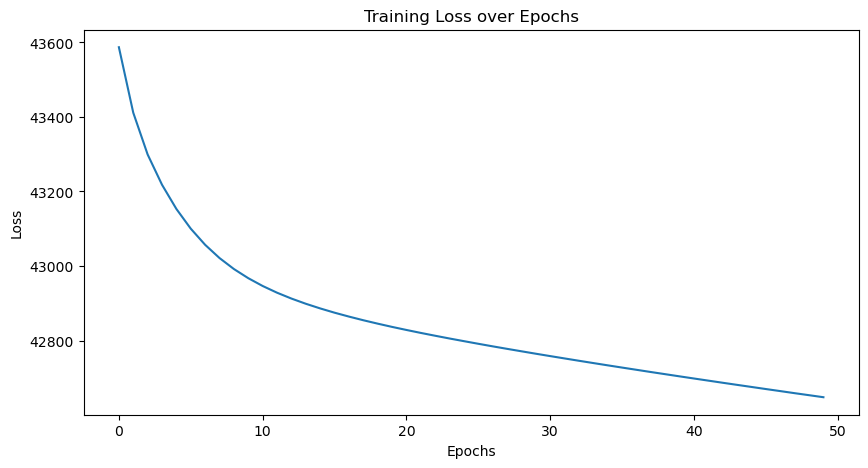

In [136]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

4. Implement Skipgram:
- Create the architecture for Skipgram, which is essentially the inverse of CBOW.
- Generate training samples. For each word in the dataset, create pairs with n surrounding words.
- Train the model using a suitable optimizer and loss function.
- Extract word embeddings for the vocabulary.



In [193]:
# Generate training samples. For each word in the dataset, create pairs with n surrounding words.
def generate_skipgram_pairs(corpus, window_size, vocab_set):
    data = []

    for i, target_word in enumerate(corpus):  
        
        # Check if the current target word is in the vocabulary
        if target_word not in vocab_set:
            continue
        
        # Define the starting and ending positions for the window
        start_index = max(0, i - window_size)
        end_index = min(len(corpus), i + window_size + 1)

        # Iterate within the window range and collect context words
        for j in range(start_index, end_index):
            # Ensure we are not collecting the target word and the word collected is in the vocabulary
            if j != i and corpus[j] in vocab_set:
                # Directly append the context word and target word pair to the data list
                data.append((corpus[j], target_word))

    return data




In [194]:
# Check the generate function for skipgram
target_pairs = generate_skipgram_pairs(subsamped_lines[:30000], 2, top_freq_words)

# print head 10
# Use target to predict contex
for i, (context, target) in enumerate(target_pairs[:10]):
    print(f"Pair {i+1}:")
    print("Context:", context)
    print("Target:", target)
    print("----------------------")

Pair 1:
Context: originated
Target: anarchism
----------------------
Pair 2:
Context: working
Target: anarchism
----------------------
Pair 3:
Context: anarchism
Target: originated
----------------------
Pair 4:
Context: working
Target: originated
----------------------
Pair 5:
Context: anarchism
Target: working
----------------------
Pair 6:
Context: originated
Target: working
----------------------
Pair 7:
Context: organization
Target: used
----------------------
Pair 8:
Context: used
Target: organization
----------------------
Pair 9:
Context: positive
Target: organization
----------------------
Pair 10:
Context: label
Target: organization
----------------------


### Analysis `generate_skipgram_pairs`


- Since, for my logic the `generate_skipgram_pairs` should use target_word to predict our context, but we need to train our model to predict the target belong to contex, then we only need to get the one context not a list of contex.

e.g. “the quick brown fox”

The target_word is brown. 

we can get:

- brown, the
- brown, quick
- brown, fox

In [195]:
# Create the architecture for Skipgram
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)
        self.activation = nn.LogSoftmax(dim = 1)

    def forward(self, context_word):
        embeds = self.embeddings(context_word)
        out = self.linear(embeds)
        out = self.activation(out)
        return out

In [199]:
# Skipgram dataset
class SkipGramDataset(Dataset):
    def __init__(self, data, word2idx):
        self.data = data
        self.word2idx = word2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        context, target = self.data[idx]
        context_index = self.word2idx[context]
        target_index = self.word2idx[target]

        return torch.tensor(context_index, dtype=torch.long), torch.tensor(target_index, dtype=torch.long)


In [210]:
# Hyperparameters
embedding_dim = 100
learning_rate = 0.01
epochs = 50
window_size = 2
BATCH_SIZE = 512

# Preparing data
vocab = set(top_freq_words)
vocab.add("<NEU>")
word2idx = {word: i for i, word in enumerate(vocab)}
idx2word = {i: word for word, i in word2idx.items()}

# Preprocess data
training_data = generate_skipgram_pairs(subsamped_lines, window_size, vocab)
skipgram_dataset = SkipGramDataset(training_data, word2idx)
max_context_size = max([len(context) for context, _ in training_data])

skipgram_loader = DataLoader(skipgram_dataset, batch_size=BATCH_SIZE, shuffle=True)

# SkipGram Model, Optimizer, Loss Function
model = SkipGram(len(vocab), embedding_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.NLLLoss()

# List to store losses
epoch_losses = []

In [211]:
# Training loop
for epoch in range(epochs):
    total_loss = 0
    for context_tensors, target_tensors in tqdm(skipgram_loader, desc=f"Epoch {epoch+1}"):
        
        context_tensors = context_tensors.to(device)
        target_tensors = target_tensors.to(device)

        optimizer.zero_grad()
        outputs = model(context_tensors)
        loss = loss_fn(outputs, target_tensors)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    epoch_losses.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss}")

Epoch 1: 100%|██████████| 11710/11710 [01:40<00:00, 116.67it/s]


Epoch 1, Loss: 109724.76208114624


Epoch 2: 100%|██████████| 11710/11710 [01:45<00:00, 111.25it/s]


Epoch 2, Loss: 109517.0359172821


Epoch 3: 100%|██████████| 11710/11710 [01:43<00:00, 113.15it/s]


Epoch 3, Loss: 109315.0285282135


Epoch 4: 100%|██████████| 11710/11710 [01:43<00:00, 112.83it/s]


Epoch 4, Loss: 109119.0927658081


Epoch 5: 100%|██████████| 11710/11710 [01:42<00:00, 113.74it/s]


Epoch 5, Loss: 108929.70387554169


Epoch 6: 100%|██████████| 11710/11710 [01:43<00:00, 113.31it/s]


Epoch 6, Loss: 108747.32620239258


Epoch 7: 100%|██████████| 11710/11710 [01:45<00:00, 111.30it/s]


Epoch 7, Loss: 108572.10669326782


Epoch 8: 100%|██████████| 11710/11710 [01:45<00:00, 111.01it/s]


Epoch 8, Loss: 108404.21571540833


Epoch 9: 100%|██████████| 11710/11710 [01:42<00:00, 114.10it/s]


Epoch 9, Loss: 108243.35635662079


Epoch 10: 100%|██████████| 11710/11710 [01:45<00:00, 111.18it/s]


Epoch 10, Loss: 108089.33552074432


Epoch 11: 100%|██████████| 11710/11710 [01:43<00:00, 113.30it/s]


Epoch 11, Loss: 107941.69553565979


Epoch 12: 100%|██████████| 11710/11710 [01:45<00:00, 111.34it/s]


Epoch 12, Loss: 107800.11761856079


Epoch 13: 100%|██████████| 11710/11710 [01:45<00:00, 111.31it/s]


Epoch 13, Loss: 107664.32171726227


Epoch 14: 100%|██████████| 11710/11710 [01:43<00:00, 112.99it/s]


Epoch 14, Loss: 107533.86717891693


Epoch 15: 100%|██████████| 11710/11710 [01:45<00:00, 111.17it/s]


Epoch 15, Loss: 107408.45379161835


Epoch 16: 100%|██████████| 11710/11710 [01:43<00:00, 112.76it/s]


Epoch 16, Loss: 107287.827003479


Epoch 17: 100%|██████████| 11710/11710 [01:45<00:00, 110.94it/s]


Epoch 17, Loss: 107171.60779476166


Epoch 18: 100%|██████████| 11710/11710 [01:45<00:00, 110.86it/s]


Epoch 18, Loss: 107059.63676452637


Epoch 19: 100%|██████████| 11710/11710 [01:43<00:00, 112.89it/s]


Epoch 19, Loss: 106951.62633132935


Epoch 20: 100%|██████████| 11710/11710 [01:45<00:00, 111.01it/s]


Epoch 20, Loss: 106847.34730243683


Epoch 21: 100%|██████████| 11710/11710 [01:43<00:00, 113.40it/s]


Epoch 21, Loss: 106746.62788677216


Epoch 22: 100%|██████████| 11710/11710 [01:45<00:00, 111.29it/s]


Epoch 22, Loss: 106649.2709569931


Epoch 23: 100%|██████████| 11710/11710 [01:45<00:00, 110.90it/s]


Epoch 23, Loss: 106555.11775112152


Epoch 24: 100%|██████████| 11710/11710 [01:43<00:00, 113.06it/s]


Epoch 24, Loss: 106464.07562065125


Epoch 25: 100%|██████████| 11710/11710 [01:44<00:00, 111.56it/s]


Epoch 25, Loss: 106375.98734474182


Epoch 26: 100%|██████████| 11710/11710 [01:43<00:00, 113.53it/s]


Epoch 26, Loss: 106290.589802742


Epoch 27: 100%|██████████| 11710/11710 [01:45<00:00, 111.20it/s]


Epoch 27, Loss: 106208.0035161972


Epoch 28: 100%|██████████| 11710/11710 [01:46<00:00, 110.45it/s]


Epoch 28, Loss: 106127.88665294647


Epoch 29: 100%|██████████| 11710/11710 [01:43<00:00, 112.80it/s]


Epoch 29, Loss: 106050.352435112


Epoch 30: 100%|██████████| 11710/11710 [01:46<00:00, 110.12it/s]


Epoch 30, Loss: 105975.19826984406


Epoch 31: 100%|██████████| 11710/11710 [01:43<00:00, 112.78it/s]


Epoch 31, Loss: 105902.3506269455


Epoch 32: 100%|██████████| 11710/11710 [01:45<00:00, 110.79it/s]


Epoch 32, Loss: 105831.72193717957


Epoch 33: 100%|██████████| 11710/11710 [01:45<00:00, 110.52it/s]


Epoch 33, Loss: 105763.26017856598


Epoch 34: 100%|██████████| 11710/11710 [01:43<00:00, 112.71it/s]


Epoch 34, Loss: 105696.86180877686


Epoch 35: 100%|██████████| 11710/11710 [01:45<00:00, 111.02it/s]


Epoch 35, Loss: 105632.409989357


Epoch 36: 100%|██████████| 11710/11710 [01:43<00:00, 112.78it/s]


Epoch 36, Loss: 105569.9308719635


Epoch 37: 100%|██████████| 11710/11710 [01:45<00:00, 110.80it/s]


Epoch 37, Loss: 105509.30939102173


Epoch 38: 100%|██████████| 11710/11710 [01:45<00:00, 110.58it/s]


Epoch 38, Loss: 105450.46190166473


Epoch 39: 100%|██████████| 11710/11710 [01:43<00:00, 112.62it/s]


Epoch 39, Loss: 105393.40020561218


Epoch 40: 100%|██████████| 11710/11710 [01:46<00:00, 109.97it/s]


Epoch 40, Loss: 105337.90055370331


Epoch 41: 100%|██████████| 11710/11710 [01:44<00:00, 111.86it/s]


Epoch 41, Loss: 105284.11916065216


Epoch 42: 100%|██████████| 11710/11710 [01:45<00:00, 111.48it/s]


Epoch 42, Loss: 105231.87408256531


Epoch 43: 100%|██████████| 11710/11710 [01:45<00:00, 110.84it/s]


Epoch 43, Loss: 105181.11592292786


Epoch 44: 100%|██████████| 11710/11710 [01:43<00:00, 112.62it/s]


Epoch 44, Loss: 105131.78853702545


Epoch 45: 100%|██████████| 11710/11710 [01:45<00:00, 110.61it/s]


Epoch 45, Loss: 105083.90895080566


Epoch 46: 100%|██████████| 11710/11710 [01:43<00:00, 112.82it/s]


Epoch 46, Loss: 105037.35309314728


Epoch 47: 100%|██████████| 11710/11710 [01:45<00:00, 111.15it/s]


Epoch 47, Loss: 104992.1618900299


Epoch 48: 100%|██████████| 11710/11710 [01:45<00:00, 110.82it/s]


Epoch 48, Loss: 104948.21873760223


Epoch 49: 100%|██████████| 11710/11710 [01:44<00:00, 112.45it/s]


Epoch 49, Loss: 104905.46620082855


Epoch 50: 100%|██████████| 11710/11710 [01:46<00:00, 110.36it/s]

Epoch 50, Loss: 104863.90305614471


### Check Model of skipgram

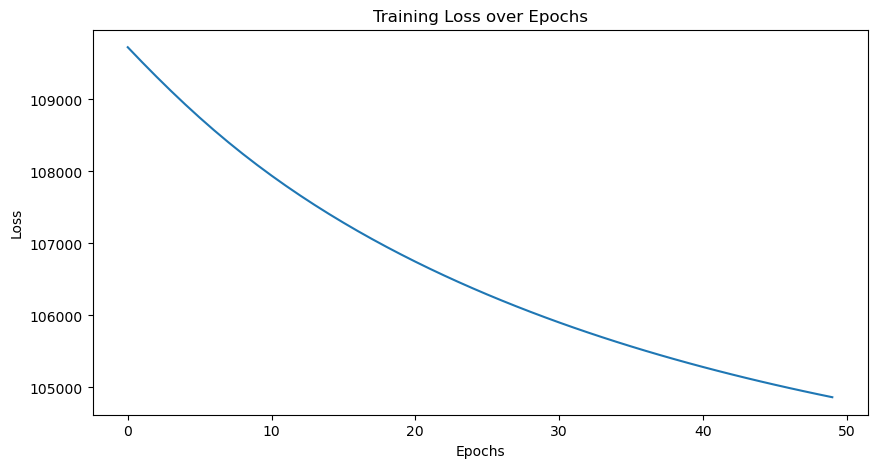

In [212]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

5. Evaluation:
- Implement a simple cosine similarity function to measure similarity between word pairs.
- Test the similarity of a few pairs of words (e.g., king & queen, man & woman, Paris & France).
- Visualize embeddings of some selected words using t-SNE or PCA.



6. Report:
- Provide a brief introduction to word embeddings, Skipgram, and CBOW.
- Discuss the architecture of the models.
- Describe the dataset and pre-processing steps.
- Present results from the evaluation step.
- Discuss challenges faced during implementation and potential improvements.
- Conclude with insights and potential applications of the implemented models.